In [0]:
##
from torchvision import datasets,transforms,utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

In [15]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

## image to tensor using torchvision 

transform = transforms.Compose([
                               transforms.ToTensor()
])
## transforms에서 자주 쓰이는 기능 
## 1. ToTensor -> image to tensor 2.Resize -> 크기조절 3. Normalize : 주어진 평균과 표준편차를 이용하여 정규화 
## 4.RandomHoriziontalFlip -> 무작위로 이미지의 오른쪽과 왼쪽을 뒤집는 기능 
## 5.RandomCrop -> 이미지를 무작위로 자르는 기능 


image_download_url = "/content/gdrive/My Drive/Colab Notebooks/pytorch/dnn/fashion_mnist/"

trainset = datasets.FashionMNIST(
    root = image_download_url,
    train = True,
    download = True,
    transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(), ## 데이터 왼쪽 오른쪽 뒤집기
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,),(0.3081,))
    ])
)
testset = datasets.FashionMNIST(
    root = image_download_url,
    train = False,
    download = True,
    transform = transforms.Compose([
                                    #transforms.RandomHorizontalFlip(), ## 데이터 왼쪽 오른쪽 뒤지빅
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,),(0.3081,))
    ])
)

In [0]:
batch_size = 16

train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = batch_size
)
test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size
)

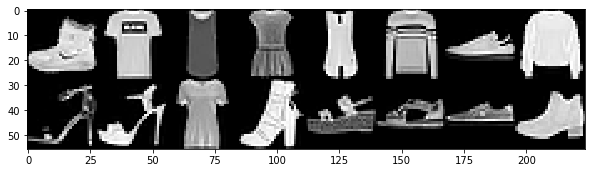

label tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


In [18]:
## 데이터 생긴거 보기~ 

dataiter = iter(train_loader)
images,labels = next(dataiter) ## next 사용해서 배치 1개 가져오기 (16개 이미지 16개 라벨)

img = utils.make_grid(images,padding=0)
np_img = img.numpy() ##img는 텐서 -> numpy로 형태로 바꿈
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(np_img,(1,2,0))) ## matplot이 인식하는 차원의 순서가 다르므로 np.transpose() -> 첫번째(0번째)차원을 맨뒤로 보냄 
plt.show()
print("label",labels)

In [19]:
CLASSES = {
    0: "티셔츠/top",
    1 : "Trouser",
    2 : "Pullover",
    3 : "드레스",
    4 : "코트",
    5 : "샌달", 
    6 : "셔츠",
    7 : "스니커즈",
    8 : "가방",
    9 : "앵글 부츠"
}
for label in labels:
  index = label.item()
  print(CLASSES[index])

앵글 부츠
티셔츠/top
티셔츠/top
드레스
티셔츠/top
Pullover
스니커즈
Pullover
샌달
샌달
티셔츠/top
앵글 부츠
샌달
샌달
스니커즈
앵글 부츠


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 52768 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54000 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 49492 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 52768 missing from current font.
  font.set_text

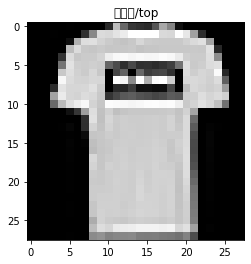

In [20]:
## 개별 이미지 확인하기 

## dataset = 28*28 크기 channel= 1 
idx = 1
item_img = images[idx]
item_np_img = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
plt.imshow(item_np_img,cmap='gray')
plt.show()

In [21]:

## DNN 만들기 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F ## nnmodule의 함수버전 
from torchvision import transforms, datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
epochs = 50
batch_size = 64
class Net(nn.Module):
  def __init__(self,dropout_p = 0.2):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(784,256) ## 28*28 =784 
    self.fc2 = nn.Linear(256,128) 
    self.fc3 = nn.Linear(128,10) ## label이 10개임으로 
    self.dropout_p = dropout_p
  def forward(self,x):
    x = x.view(-1,784)
    x = F.relu(self.fc1(x))

    x = F.dropout(x,training=self.training,p = self.dropout_p)

    x = F.relu(self.fc2(x))
    x = F.dropout(x,training=self.training,p = self.dropout_p)
    x = self.fc3(x)

    return x

model = Net(dropout_p=0.2).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)

def train(model,train_loader,optimizer):
  model.train()##학습모드로 바꿔놓고 
  
  for batch_idx,(data,target) in enumerate(train_loader): ## data 모양은 (배치크기 ,색 ,높이 ,넓이) [64,1,28,28]
    data, target = data.to(device) , target.to(device) ##model 자체를 gpu로 보냈음으로 
    
    ##매학습마다 기울기 초기화 
    optimizer.zero_grad()
    out_label = model(data)
    loss = F.cross_entropy(out_label,target) ## target이 real label
    loss.backward()
    optimizer.step()


def evaluate(model, test_loader) : ##평가함수 
  model.eval() ## model을 평가모드로 바꾸기 
  test_loss =0
  correct = 0

  ##평가 과정에서는 기울기 계산 필요없음 
  with torch.no_grad():
    for data, target in test_loader :
      data , target = data.to(device),target.to(device)
      output = model (data)
      test_loss += F.cross_entropy(output,target,reduction='sum').item() ##reduction == sum -> 미니배치의 평균 대신 합 
      
      ## output.max() -> 2개의 값 출력 , 가장 큰 값과 인덱스 
      ## .eq() -> 값이 일치하는지 확인하는 것 
      pred = output.max(1,keepdim=True)[1]  ## index 뽑기 
      correct += pred.eq(target.view_as(pred)).sum().item() ## view_as -> target텐서를 pred 모양대로 다시 정렬 
  
  test_loss /= len(test_loader.dataset)
  print("len test_lodaer dataset",len(test_loader.dataset))
  test_accuracy = 100 * correct /len(test_loader.dataset)
  return test_loss, test_accuracy


In [23]:
for epoch in range(1,epochs+1):
  train(model,train_loader,optimizer)
  test_loss , test_accuracy = evaluate(model,test_loader)

  print("[{}] test loss : {:.4f}, accuracy : {:.2f}%".format(epoch,test_loss,test_accuracy))


len test_lodaer dataset 10000
[1] test loss : 0.5668, accuracy : 80.16%
len test_lodaer dataset 10000
[2] test loss : 0.4881, accuracy : 82.35%
len test_lodaer dataset 10000
[3] test loss : 0.4490, accuracy : 83.92%
len test_lodaer dataset 10000
[4] test loss : 0.4239, accuracy : 84.81%
len test_lodaer dataset 10000
[5] test loss : 0.4047, accuracy : 85.56%
len test_lodaer dataset 10000
[6] test loss : 0.3929, accuracy : 85.83%
len test_lodaer dataset 10000
[7] test loss : 0.3820, accuracy : 86.28%
len test_lodaer dataset 10000
[8] test loss : 0.3733, accuracy : 86.51%
len test_lodaer dataset 10000
[9] test loss : 0.3657, accuracy : 86.89%
len test_lodaer dataset 10000
[10] test loss : 0.3597, accuracy : 87.05%
len test_lodaer dataset 10000
[11] test loss : 0.3558, accuracy : 87.18%
len test_lodaer dataset 10000
[12] test loss : 0.3518, accuracy : 87.45%
len test_lodaer dataset 10000
[13] test loss : 0.3506, accuracy : 87.45%
len test_lodaer dataset 10000
[14] test loss : 0.3486, accur

In [29]:
## 데이터 양 늘리고 dropout 적용 시 
for epoch in range(1,epochs+1):
  train(model,train_loader,optimizer)
  test_loss , test_accuracy = evaluate(model,test_loader)

  print("[{}] test loss : {:.4f}, accuracy : {:.2f}%".format(epoch,test_loss,test_accuracy))


len test_lodaer dataset 10000
[1] test loss : 0.4879, accuracy : 82.36%
len test_lodaer dataset 10000
[2] test loss : 0.4347, accuracy : 84.00%
len test_lodaer dataset 10000
[3] test loss : 0.4049, accuracy : 85.28%
len test_lodaer dataset 10000
[4] test loss : 0.3924, accuracy : 85.84%
len test_lodaer dataset 10000
[5] test loss : 0.3700, accuracy : 86.58%
len test_lodaer dataset 10000
[6] test loss : 0.3695, accuracy : 86.38%
len test_lodaer dataset 10000
[7] test loss : 0.3548, accuracy : 86.93%
len test_lodaer dataset 10000
[8] test loss : 0.3448, accuracy : 87.44%
len test_lodaer dataset 10000
[9] test loss : 0.3523, accuracy : 87.17%
len test_lodaer dataset 10000
[10] test loss : 0.3397, accuracy : 87.63%
len test_lodaer dataset 10000
[11] test loss : 0.3397, accuracy : 87.89%
len test_lodaer dataset 10000
[12] test loss : 0.3323, accuracy : 88.18%
len test_lodaer dataset 10000
[13] test loss : 0.3301, accuracy : 88.20%
len test_lodaer dataset 10000
[14] test loss : 0.3284, accur